In [1]:
# Importing necessary libraries

# General utilities
import os
from itertools import cycle

# Data handling and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# PyTorch related imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split

# torchvision for data transformation and network architectures
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage

# Network architecture
from network import Net

# Scikit-learn for evaluation
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, 
    classification_report, roc_auc_score
)
from sklearn.preprocessing import label_binarize


In [3]:
# Check for CUDA availability and print related information.
# This includes whether CUDA is available, the CUDA version, and the CUDNN version.
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("CUDNN Version:", torch.backends.cudnn.version())

# If CUDA is available, print details about the available GPU(s).
# This includes the number of GPUs, the name of the first GPU, and the index of the currently used GPU.
if torch.cuda.is_available():
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.current_device())
else:
    # If CUDA is not available, notify that the CPU will be used instead.
    print("CUDA is not available. Using CPU.")


CUDA Available: True
CUDA Version: 12.1
CUDNN Version: 8907
1
NVIDIA GeForce RTX 4070 Laptop GPU
0


In [4]:
# Define the sequence of transformations for the training dataset.
# These transformations include random horizontal flip, random rotation by 45 degrees,
# random autocontrast adjustment, conversion to a tensor, and resizing to 128x128 pixels.
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

# Define the sequence of transformations for the test dataset.
# These transformations include conversion to a tensor and resizing to 128x128 pixels.
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])


In [5]:
# Run data_sep.py before runing this code
# Load the training dataset from the specified directory.
# Apply the defined training transformations to the dataset.
dataset_train = ImageFolder(
    "dataset/Fruit And Vegetable Diseases Dataset/entrainement",
    transform = train_transforms
)

# Load the test dataset from the specified directory.
# Apply the defined test transformations to the dataset.
dataset_test = ImageFolder(
    "dataset/Fruit And Vegetable Diseases Dataset/test",
    transform = test_transforms
)


In [6]:
# Display the classes in the training dataset.
print("Classes in the training dataset:", dataset_train.classes)

Classes in the training dataset: ['Apple__Healthy', 'Apple__Rotten', 'Banana__Healthy', 'Banana__Rotten', 'Bellpepper__Healthy', 'Bellpepper__Rotten', 'Carrot__Healthy', 'Carrot__Rotten', 'Cucumber__Healthy', 'Cucumber__Rotten', 'Grape__Healthy', 'Grape__Rotten', 'Guava__Healthy', 'Guava__Rotten', 'Jujube__Healthy', 'Jujube__Rotten', 'Mango__Healthy', 'Mango__Rotten', 'Orange__Healthy', 'Orange__Rotten', 'Pomegranate__Healthy', 'Pomegranate__Rotten', 'Potato__Healthy', 'Potato__Rotten', 'Strawberry__Healthy', 'Strawberry__Rotten', 'Tomato__Healthy', 'Tomato__Rotten']


In [7]:
# Create DataLoaders for training and testing datasets with multiple workers.
# DataLoaders facilitate the loading of data in batches and can utilize multiple CPU cores for efficiency.

train_loader = DataLoader(
    dataset_train,
    batch_size=128,  # Ajust if necessary
    shuffle=True,  # Shuffle the training data to ensure randomness
    num_workers=14  # Adjust based on observed performance and available CPU cores
)

test_loader = DataLoader(
    dataset_test,
    batch_size=128,  # Use the same batch size for consistency
    shuffle=False,  # No need to shuffle the test data
    num_workers=14  # Adjust based on observed performance and available CPU cores
)


In [8]:
# Retrieve the first batch of images and labels from the test DataLoader.
image, label = next(iter(test_loader))

# Print the dimensions of the tensor containing the images.
# This will show the shape of the tensor, which typically includes
# the batch size, number of channels, height, and width.
print(image.shape)


torch.Size([128, 3, 128, 128])


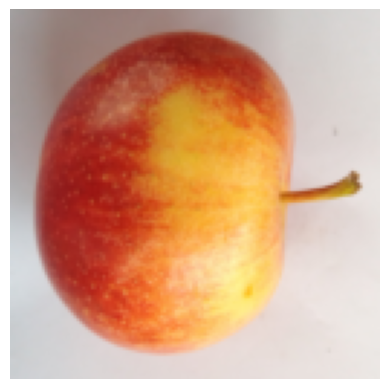

In [10]:
# Select the first image from the batch.
first_image = image[0]

# Apply permute to rearrange the dimensions and place the RGB channels in the last position.
first_image = first_image.permute(1, 2, 0)

# Display the image using matplotlib.
plt.imshow(first_image)
plt.axis('off')  # Hide the axes for a cleaner visualization.
plt.show()

In [11]:
# Determine the device to be used for computation.
# Use CUDA (GPU) if available, otherwise default to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the neural network model with the specified number of output classes.
# Move the model to the selected device (GPU or CPU).
net = Net(num_classes=28).to(device)


In [21]:
# Neural network

# Initializations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(num_classes=28).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

train_losses = []
val_losses = []
early_stopping_patience = 5
min_val_loss = float('inf')
patience_counter = 0

# Drive loop
num_epochs = 50  
for epoch in range(num_epochs):
    running_loss = 0.0
    net.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = net(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()

    # Calculation of validation loss
    net.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_features, val_labels in test_loader:
            val_features, val_labels = val_features.to(device), val_labels.to(device)
            with torch.cuda.amp.autocast():
                val_outputs = net(val_features)
                val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

    epoch_loss = running_loss / len(train_loader)
    val_epoch_loss = val_running_loss / len(test_loader)

    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')

    # Early stopping
    if val_epoch_loss < min_val_loss:
        min_val_loss = val_epoch_loss
        patience_counter = 0
        torch.save(net.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break

Epoch [1/50], Train Loss: 2.2402, Validation Loss: 1.3740
Epoch [2/50], Train Loss: 1.4084, Validation Loss: 1.0564
Epoch [3/50], Train Loss: 1.0687, Validation Loss: 0.9946
Epoch [4/50], Train Loss: 0.9450, Validation Loss: 0.8345
Epoch [5/50], Train Loss: 0.9356, Validation Loss: 0.6240
Epoch [6/50], Train Loss: 0.8211, Validation Loss: 0.5820
Epoch [7/50], Train Loss: 0.6978, Validation Loss: 0.5228
Epoch [8/50], Train Loss: 0.6739, Validation Loss: 0.4800
Epoch [9/50], Train Loss: 0.6348, Validation Loss: 0.4877
Epoch [10/50], Train Loss: 0.6232, Validation Loss: 0.4433
Epoch [11/50], Train Loss: 0.5918, Validation Loss: 0.4584
Epoch [12/50], Train Loss: 0.6094, Validation Loss: 0.4005
Epoch [13/50], Train Loss: 0.5909, Validation Loss: 0.4485
Epoch [14/50], Train Loss: 0.6202, Validation Loss: 1.3489
Epoch [15/50], Train Loss: 0.8768, Validation Loss: 0.4788
Epoch [16/50], Train Loss: 0.6095, Validation Loss: 0.3573
Epoch [17/50], Train Loss: 0.5546, Validation Loss: 0.3903
Epoch 

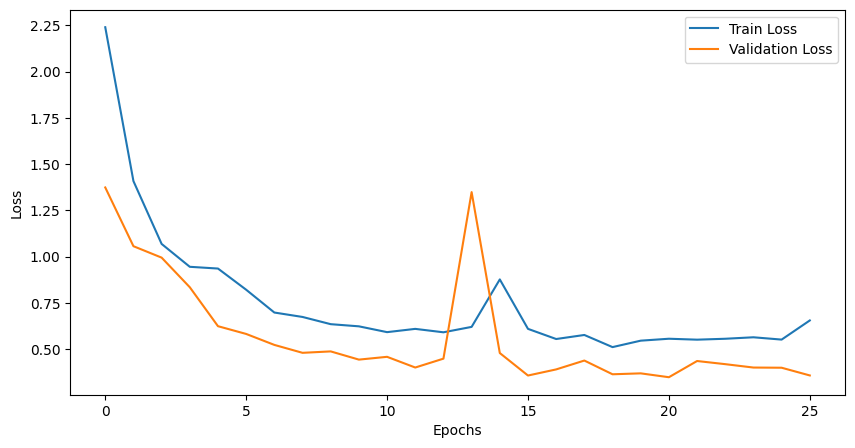

In [22]:
# Visualize the loss curves for training and validation.
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Load the best model after early stopping
net.load_state_dict(torch.load('nn_model/best_model.pth'))

<All keys matched successfully>

In [13]:
# Set the model to evaluation mode.
net.eval()

# Initialize lists to store true labels, predicted labels, and probabilities.
all_labels = []
all_preds = []
all_probs = []

# Disable gradient calculation for efficiency during evaluation.
with torch.no_grad():
    # Iterate over the test data.
    for images, labels in test_loader:
        # Move images and labels to the selected device (GPU or CPU).
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass: compute outputs.
        outputs = net(images)
        
        # Get the predicted class by finding the index with the maximum score.
        _, preds = torch.max(outputs, 1)
        
        # Compute the probabilities using softmax.
        probs = torch.softmax(outputs, dim=1)
        
        # Store the true labels, predicted labels, and probabilities in the respective lists.
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for easier manipulation and analysis.
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)


In [14]:
# Calculate overall performance metrics.
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Display the overall performance metrics.
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate and display the classification report for each class.
report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
print(report)

# Calculate the AUC (Area Under the Curve) score for each class.
auc_scores = roc_auc_score(all_labels, all_probs, multi_class='ovr')
print(f'ROC AUC Scores: {auc_scores}')


Precision: 0.9163
Recall: 0.9124
F1 Score: 0.9130
                      precision    recall  f1-score   support

      Apple__Healthy       0.97      0.96      0.97       488
       Apple__Rotten       0.95      0.92      0.94       586
     Banana__Healthy       0.95      0.95      0.95       400
      Banana__Rotten       0.97      0.97      0.97       560
 Bellpepper__Healthy       0.79      0.92      0.85       123
  Bellpepper__Rotten       0.64      0.65      0.64       119
     Carrot__Healthy       0.72      0.93      0.81       124
      Carrot__Rotten       0.67      0.75      0.71       116
   Cucumber__Healthy       0.92      0.84      0.88       122
    Cucumber__Rotten       0.97      0.82      0.89       119
      Grape__Healthy       0.72      0.70      0.71        40
       Grape__Rotten       0.69      0.93      0.79        40
      Guava__Healthy       0.95      0.93      0.94        40
       Guava__Rotten       0.97      0.78      0.86        40
     Jujube__Health

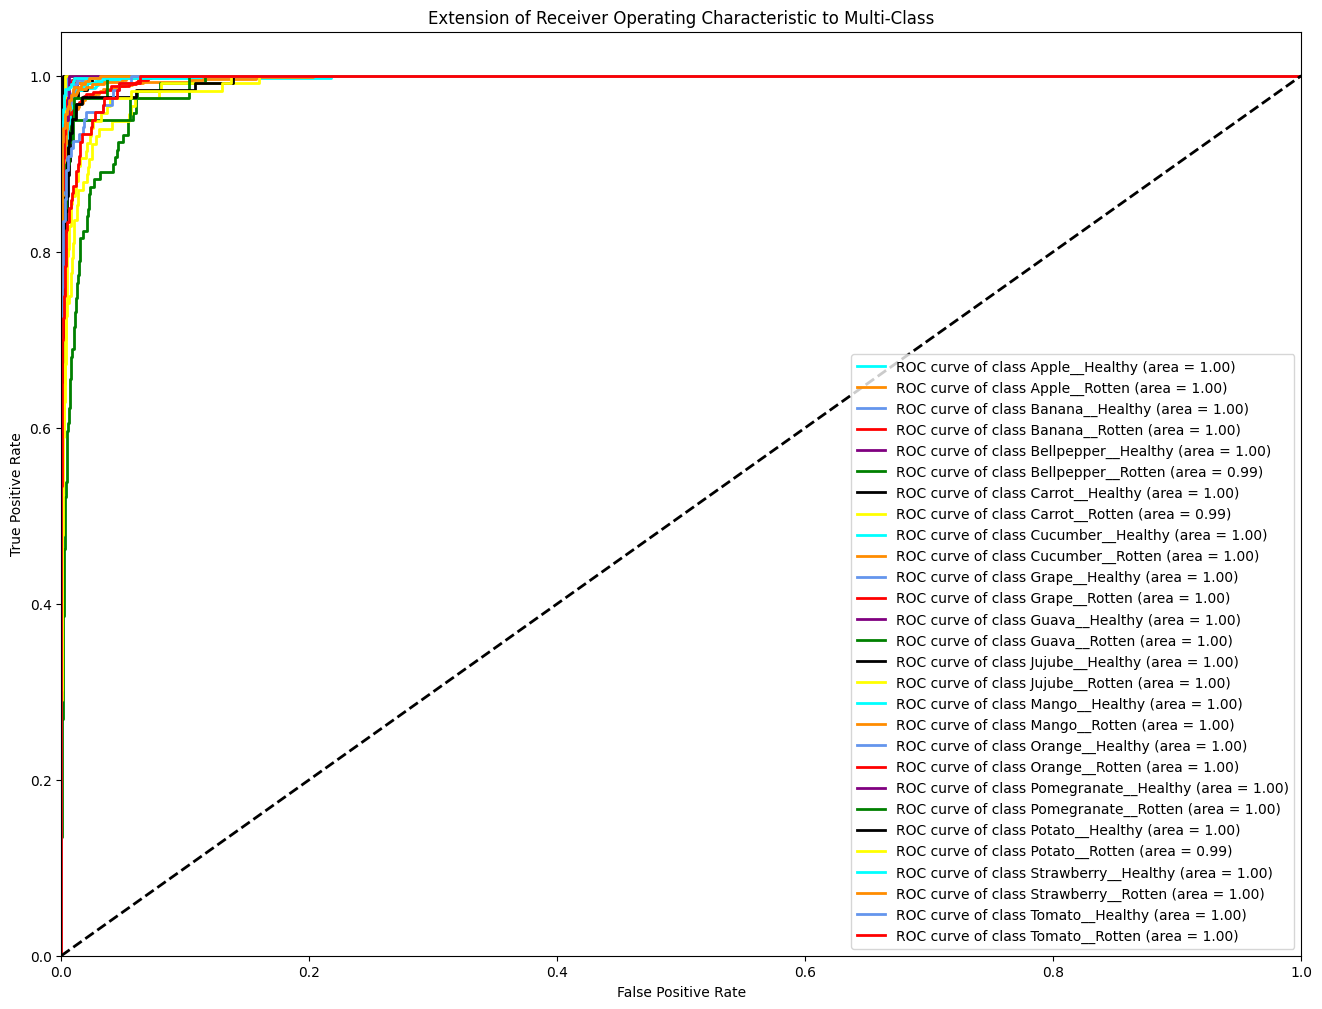

In [15]:
# Binarize the labels for multi-class ROC calculation.
classes = test_loader.dataset.classes
n_classes = len(classes)
y_test = label_binarize(all_labels, classes=range(n_classes))

# Calculate ROC scores for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class.
plt.figure(figsize=(16, 12))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'black', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

# Plot the diagonal line representing random chance.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [16]:
# Testing the model

# Initialize the device to use (GPU if available, otherwise CPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the neural network model with the specified number of classes and move it to the selected device.
model = Net(num_classes=28).to(device)

# Load the saved model parameters (state_dict) from the specified file and map it to the appropriate device.
model.load_state_dict(torch.load('nn_model/best_model.pth', map_location=device))

# Set the model to evaluation mode.
model.eval()


Net(
  (features_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ELU(alpha=1.0)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in

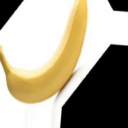

Predicted class: Banana__Healthy


In [20]:
# Load an image
image_path = r'dataset\Fruit And Vegetable Diseases Dataset\test\Banana__Healthy\Banana__Healthy_augmented_7.jpg'
image = Image.open(image_path).convert('RGB')  # Convert to RGB if necessary

# Apply test transformations
input_tensor = test_transforms(image)

# Add a batch dimension
input_tensor = input_tensor.unsqueeze(0).to(device)  # Models generally expect a batch of images

# Visualize the image:
output_tensor = input_tensor.cpu().squeeze(0)  # Remove the batch dimension and copy to CPU
output_image = ToPILImage()(output_tensor)
display(output_image)

# Make a prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

# Assuming you have a list of category names
categories = test_loader.dataset.classes
print(f'Predicted class: {categories[predicted.item()]}')